In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib

from astropy.table import Table
import astropy.io.fits as fits

from scipy.optimize import curve_fit

from glob import glob

matplotlib.rcParams.update({'font.size':18})
matplotlib.rcParams.update({'font.family':'serif'})

ftype = '.pdf'

from astropy.stats import LombScargle
from stuff import FINDflare

import exoplanet as xo

In [17]:
# tess_dir = '/data/epyc/data/tess/'
tess_dir = '/Users/james/Desktop/tess/'

sectors = ['sector001', 'sector002', 'sector003', 'sector004']

# just in case glob wants to re-order things, be sure grab them in Sector order
sect1 = glob(tess_dir + sectors[0] + '/*.fits', recursive=True)
sect2 = glob(tess_dir + sectors[1] + '/*.fits', recursive=True)
sect3 = glob(tess_dir + sectors[2] + '/*.fits', recursive=True)
sect4 = glob(tess_dir + sectors[3] + '/*.fits', recursive=True)

files = sect1 + sect2 + sect3 + sect4
print(len(sect1), len(sect2), len(sect3), len(sect4), len(files))

15889 15990 15991 19996 67866


Text(0, 0.5, 'Dec [deg]')

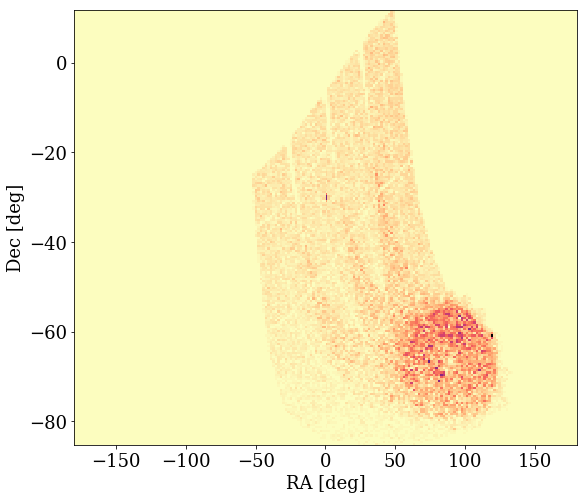

In [18]:
df1 = pd.read_csv(tess_dir + 'gaiatess1_xmatch_1arsec-result.csv')
df2 = pd.read_csv(tess_dir + 'gaiatess2_xmatch_1arsec-result.csv')
df3 = pd.read_csv(tess_dir + 'gaiatess3_xmatch_1arsec-result.csv')
df4 = pd.read_csv(tess_dir + 'gaiatess4_xmatch_1arsec-result.csv')

df = pd.concat([df1, df2, df3, df4], ignore_index=True, sort=False)

plt.figure(figsize=(9,8))
_ = plt.hist2d(df['ra'], df['dec'], bins=(200,200), cmap=plt.cm.magma_r)
_ = plt.hist2d(df['ra']-360, df['dec'], bins=(200,200), cmap=plt.cm.magma_r)
plt.xlim(-180,180)
plt.xlabel('RA [deg]')
plt.ylabel('Dec [deg]')


In [20]:
%%time
per_out = np.zeros(len(files)) -1 
per_amp = np.zeros(len(files)) -1 
per_med = np.zeros(len(files)) -1 
per_std = np.zeros(len(files)) -1 


FL_id = np.array([])
FL_t0 = np.array([]) 
FL_t1 = np.array([])
FL_f0 = np.array([])
FL_f1 = np.array([])

for k in range(len(files)):
    tbl = -1
    df = -1
    try:
        tbl = Table.read(files[k], format='fits')
        df = tbl.to_pandas()
        
        # make harsh quality cuts, and chop out a known bad window of time
        AOK = (tbl['QUALITY'] == 0) & ((tbl['TIME'] < 1347) | (tbl['TIME'] > 1350))
        
        if sum(AOK) > 1000:
            # do a running median for a basic smooth
            smo = df['PDCSAP_FLUX'][AOK].rolling(128, center=True).median()
            med = np.nanmedian(smo)
            
            #find OK points in the smoothed LC
            SOK = np.isfinite(smo)

            
            FL = FINDflare((df['PDCSAP_FLUX'][AOK][SOK] - smo[SOK])/med, 
                           df['PDCSAP_FLUX_ERR'][AOK][SOK]/med, 
                           N1=3, N2=1, N3=4)


            LS = LombScargle(df['TIME'][AOK][SOK], smo[SOK]/med, dy=df['PDCSAP_FLUX_ERR'][AOK][SOK]/med)
            frequency, power = LS.autopower(minimum_frequency=1./40., 
                                            maximum_frequency=1./0.1, 
                                            samples_per_peak=7)
            best_frequency = frequency[np.argmax(power)]

            per_out[k] = 1./best_frequency
            per_amp[k] = np.nanmax(power)
            per_med[k] = np.nanmedian(power)
            per_std[k] = np.nanstd(smo[SOK]/med)

            if np.size(FL) > 0:
                for i in range(len(FL[0])):
                    FL_id = np.append(FL_id, k)
                    FL_t0 = np.append(FL_t0, FL[0][i])
                    FL_t1 = np.append(FL_t1, FL[1][i])
                    FL_f0 = np.append(FL_f0, med)
                    FL_f1 = np.append(FL_f1, np.nanmax(tbl['PDCSAP_FLUX'][AOK][SOK][(FL[0][i]):(FL[1][i]+1)]))


            # make output plots?
#             if True:

            # make them every 100th file
            if (k % 100 == 0):
                print('fig. K = '+str(k))
                plt.figure(figsize=(12,9))

                plt.errorbar(tbl['TIME'][AOK], tbl['PDCSAP_FLUX'][AOK]/med, yerr=tbl['PDCSAP_FLUX_ERR'][AOK]/med, 
                             linestyle=None, alpha=0.25, label='PDC_FLUX')
                plt.plot(tbl['TIME'][AOK], smo/med, label='128pt MED')

                Smed = np.nanmedian(tbl['SAP_FLUX'][AOK])
                plt.errorbar(tbl['TIME'][AOK], tbl['SAP_FLUX'][AOK]/Smed, yerr=tbl['SAP_FLUX_ERR'][AOK]/Smed, 
                             linestyle=None, alpha=0.25, label='SAP_FLUX')

            
                if np.size(FL) > 0:
                    for i in range(len(FL[0])):
                        plt.scatter(tbl['TIME'][AOK][SOK][(FL[0][i]):(FL[1][i]+1)], 
                                    tbl['PDCSAP_FLUX'][AOK][SOK][(FL[0][i]):(FL[1][i]+1)] / med, color='r', 
                                    label='_nolegend_')

                if np.nanmax(power) > 0.2:
                    LSmodel = LS.model(df['TIME'][AOK][SOK], best_frequency)
                    plt.plot(df['TIME'][AOK][SOK], LSmodel, label='P='+format(1./best_frequency, '6.3f')+'d')            

                plt.title(files[k].split('/')[-1], fontsize=12)
                plt.ylabel('Flux')
                plt.xlabel('BJD - 2457000 (days)')
                plt.legend(fontsize=10)
#                 plt.show()
                plt.savefig('figures/' + files[k].split('/')[-1] + '.jpeg', bbox_inches='tight', pad_inches=0.25)
                plt.close()
        
    except (OSError, KeyError, TypeError, ValueError):
        print('k=' + str(k) + ' bad file: ' + files[k])

fig. K = 0
fig. K = 100
fig. K = 200
fig. K = 300
fig. K = 400
fig. K = 500
fig. K = 600
fig. K = 700
fig. K = 800
fig. K = 900
fig. K = 1000
fig. K = 1100
fig. K = 1200
fig. K = 1300
fig. K = 1400
fig. K = 1500
fig. K = 1600
fig. K = 1700
fig. K = 1800
fig. K = 1900
fig. K = 2000
fig. K = 2100
fig. K = 2200
fig. K = 2300
fig. K = 2400
fig. K = 2500
fig. K = 2600
k=2622 bad file: /Users/james/Desktop/tess/sector001/tess2018206045859-s0001-0000000425878763-0120-s_lc.fits
fig. K = 2700
fig. K = 2800
fig. K = 2900
fig. K = 3000
fig. K = 3100
fig. K = 3200
fig. K = 3300
fig. K = 3400
fig. K = 3500
fig. K = 3600
fig. K = 3700
fig. K = 3800
fig. K = 3900
fig. K = 4000
fig. K = 4100
fig. K = 4200
fig. K = 4300
fig. K = 4400
fig. K = 4500
fig. K = 4600
fig. K = 4700
fig. K = 4800
fig. K = 4900
fig. K = 5000
fig. K = 5100
fig. K = 5200
fig. K = 5300
fig. K = 5400
fig. K = 5500
fig. K = 5600
fig. K = 5700
fig. K = 5800
fig. K = 5900
fig. K = 6000
fig. K = 6100
fig. K = 6200
fig. K = 6300
fig. K 

k=35448 bad file: /Users/james/Desktop/tess/sector003/tess2018263035959-s0003-0000000038584634-0123-s_lc.fits
fig. K = 35500
fig. K = 35600
fig. K = 35700
fig. K = 35800
fig. K = 35900
fig. K = 36000
fig. K = 36100
fig. K = 36200
fig. K = 36300
fig. K = 36400
fig. K = 36500
fig. K = 36600
fig. K = 36700
fig. K = 36800
fig. K = 36900
fig. K = 37000
fig. K = 37100
fig. K = 37200
fig. K = 37300
fig. K = 37400
k=37410 bad file: /Users/james/Desktop/tess/sector003/tess2018263035959-s0003-0000000248948786-0123-s_lc.fits
fig. K = 37500
fig. K = 37600
fig. K = 37700
fig. K = 37800
fig. K = 37900
fig. K = 38000
fig. K = 38100
k=38162 bad file: /Users/james/Desktop/tess/sector003/tess2018263035959-s0003-0000000333557721-0123-s_lc.fits
fig. K = 38200
fig. K = 38300
fig. K = 38400
fig. K = 38500
fig. K = 38600
fig. K = 38700
fig. K = 38800
fig. K = 38900
fig. K = 39000
fig. K = 39100
fig. K = 39200
fig. K = 39300
fig. K = 39400
fig. K = 39500
fig. K = 39600
fig. K = 39700
fig. K = 39800
fig. K = 3

k=47852 bad file: /Users/james/Desktop/tess/sector003/tess2018263035959-s0003-0000000003806094-0123-s_lc.fits
fig. K = 47900
fig. K = 48000
fig. K = 48100
k=48114 bad file: /Users/james/Desktop/tess/sector004/tess2018292075959-s0004-0000000176831909-0124-s_lc.fits
fig. K = 48200
fig. K = 48300
fig. K = 48400
k=48458 bad file: /Users/james/Desktop/tess/sector004/tess2018292075959-s0004-0000000260659412-0124-s_lc.fits
fig. K = 48500
fig. K = 48600
k=48666 bad file: /Users/james/Desktop/tess/sector004/tess2018292075959-s0004-0000000260243101-0124-s_lc.fits
fig. K = 48700
fig. K = 48800
fig. K = 48900
fig. K = 49000
fig. K = 49100
fig. K = 49200
fig. K = 49300
fig. K = 49400
fig. K = 49500
fig. K = 49600
fig. K = 49700
fig. K = 49800
fig. K = 49900
fig. K = 50000
fig. K = 50100
fig. K = 50200
fig. K = 50300
fig. K = 50400
fig. K = 50500
fig. K = 50600
fig. K = 50700
fig. K = 50800
fig. K = 50900
fig. K = 51000
k=51093 bad file: /Users/james/Desktop/tess/sector004/tess2018292075959-s0004-00

Text(0, 0.5, '# stars')

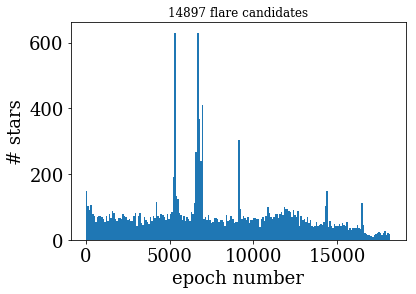

In [21]:
Nfl, Bfl, Pt = plt.hist((FL_t0+FL_t1)/2.,bins=200)

plt.title(str(np.size(FL_t0))+' flare candidates',fontsize=12)
plt.xlabel('epoch number')
plt.ylabel('# stars')

In [22]:
print(len(sect1), len(sect2), len(sect3), len(files))

print(len(FL_id))

15889 15990 15991 67866
14897


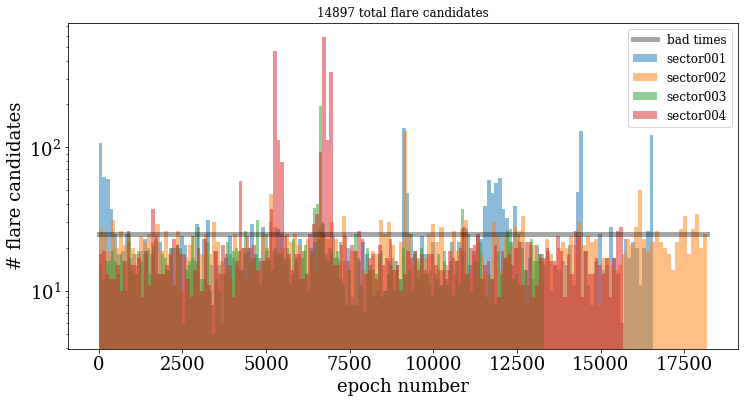

In [40]:
plt.figure(figsize=(12,6))

s1 = np.where((FL_id < len(sect1)))[0]
s2 = np.where((FL_id > len(sect1)) & 
              (FL_id < len(sect1) + len(sect2)))[0]
s3 = np.where((FL_id > len(sect1) + len(sect2)) & 
              (FL_id < len(sect1) + len(sect2) + len(sect3)))[0]
s4 = np.where((FL_id > len(sect1) + len(sect2) + len(sect4)))[0]


_ = plt.hist((FL_t0[s1]+FL_t1[s1])/2., bins=150, alpha=0.5, label='sector001')
_ = plt.hist((FL_t0[s2]+FL_t1[s2])/2., bins=150, alpha=0.5, label='sector002')
_ = plt.hist((FL_t0[s3]+FL_t1[s3])/2., bins=150, alpha=0.5, label='sector003')
_ = plt.hist((FL_t0[s4]+FL_t1[s4])/2., bins=150, alpha=0.5, label='sector004')

plt.plot([0, max(FL_t1)], [25,25], lw=5, alpha=0.35, c='k', label='bad times')

plt.title(str(np.size(FL_t0))+' total flare candidates',fontsize=12)
plt.xlabel('epoch number')
plt.ylabel('# flare candidates')
plt.legend(fontsize=12)
plt.yscale('log')
plt.savefig('flare_hist.jpeg', dpi=150, bbox_inches='tight', pad_inches=0.25)

In [24]:
ALL_TIC = pd.Series(files).str.split('-', expand=True).iloc[:,-3].astype('int')

In [25]:
flare_out = pd.DataFrame(data={'TIC':ALL_TIC[FL_id], 'i0':FL_t0, 'i1':FL_t1, 'med':FL_f0, 'peak':FL_f1})
flare_out.to_csv('flare_out_v03.csv')

In [26]:
rot_out = pd.DataFrame(data={'TIC':ALL_TIC, 
                             'per':per_out, 'Pamp':per_amp, 'Pmed':per_med, 'StdLC':per_std})
rot_out.to_csv('rot_out_v03.csv')

In [27]:
# ffok = np.isfinite(flare_out['peak']) & np.isfinite(flare_out['med'])
# _ = plt.hist(np.log10(flare_out['peak'][ffok]/flare_out['med'][ffok]),bins=100)
# plt.xlabel('log (Flare Peak / LC Median)')
# plt.yscale('log')

In [28]:
# _ = plt.hist(flare_out['TIC'],bins=100)
uTIC, NTIC = np.unique(flare_out['TIC'].values, return_counts=True)
imax = np.argmax(NTIC)
print(uTIC[imax], NTIC[imax])

150357290 110


In [29]:
# kk = np.where((ALL_TIC == uTIC[imax]))[0]

# for k in kk:
#     tbl = Table.read(files[k], format='fits')
#     df = tbl.to_pandas()
#     AOK = tbl['QUALITY'] == 0
#     if sum(AOK) > 10:
#         smo = df['PDCSAP_FLUX'][AOK].rolling(128, center=True).median()
#         med = np.nanmedian(smo)
#         SOK = np.isfinite(smo)

#         FL = FINDflare((df['PDCSAP_FLUX'][AOK][SOK] - smo[SOK])/med, df['PDCSAP_FLUX_ERR'][AOK][SOK]/med, 
#                        N1=3, N2=1, N3=3)


#         LS = LombScargle(df['TIME'][AOK][SOK], smo[SOK]/med, dy=df['PDCSAP_FLUX_ERR'][AOK][SOK]/med)
#         frequency, power = LS.autopower(minimum_frequency=1./20., maximum_frequency=1./0.1)
#         best_frequency = frequency[np.argmax(power)]


#         # make output plots?
#         plt.figure(figsize=(12,9))
#         plt.errorbar(tbl['TIME'][AOK], tbl['PDCSAP_FLUX'][AOK], yerr=tbl['PDCSAP_FLUX_ERR'][AOK], 
#                      linestyle=None, alpha=0.25, label='PDCFLUX')

#         plt.plot(tbl['TIME'][AOK], smo, label='128pt MED')
#         if np.size(FL) > 0:
#             for i in range(len(FL[0])):
#                 plt.scatter(tbl['TIME'][AOK][SOK][(FL[0][i]):(FL[1][i]+1)], 
#                             tbl['PDCSAP_FLUX'][AOK][SOK][(FL[0][i]):(FL[1][i]+1)], color='r', label='_nolegend_')

#         if np.nanmax(power) > 0.25:
#             LSmodel = LS.model(df['TIME'][AOK][SOK], best_frequency)
#             plt.plot(df['TIME'][AOK][SOK], LSmodel * med, label='P='+format(1./best_frequency, '6.3f')+'d')            

#         plt.title(files[k].split('/')[-1], fontsize=12)
#         plt.ylabel('Flux')
#         plt.xlabel('MJD')
#         plt.legend(fontsize=12)
#         plt.show()
#             # plt.savefig('test1.jpeg', bbox_inches='tight', pad_inches=0.25)

In [42]:
df = pd.concat([df1, df2, df3, df4], ignore_index=True, sort=False)

In [43]:
# NOW MATCH OUTPUT TO GAIA FILE, PLOT ROTATION ON THE CMD, AND PROT VS COLOR

In [44]:
gdata = pd.merge(df, rot_out, right_on='TIC', left_on='ticid')

In [45]:
# gdata.columns.values

In [46]:
ok = np.where(np.isfinite(gdata[u'parallax']) & # this is basically the same as the TGAS file...
              (gdata[u'parallax_error'] / gdata[u'parallax'] < 0.1) &
              (gdata[u'modality_flag'] == 1) & 
              (gdata[u'result_flag'] == 1) &
              np.isfinite(gdata[u'bp_rp']) & 
              (gdata[u'phot_bp_mean_flux_error']/gdata[u'phot_bp_mean_flux'] < 0.01) & 
              (gdata[u'phot_rp_mean_flux_error']/gdata[u'phot_rp_mean_flux'] < 0.01) & 
              (gdata[u'phot_g_mean_flux_error']/gdata[u'phot_g_mean_flux'] < 0.01) & 
              (gdata['per'] > 0.1) & 
              (gdata['Pamp']/gdata['Pmed'] > 200) & 
              (gdata['Pamp'] > 0.5))[0]
print(ok.shape)

(19597,)


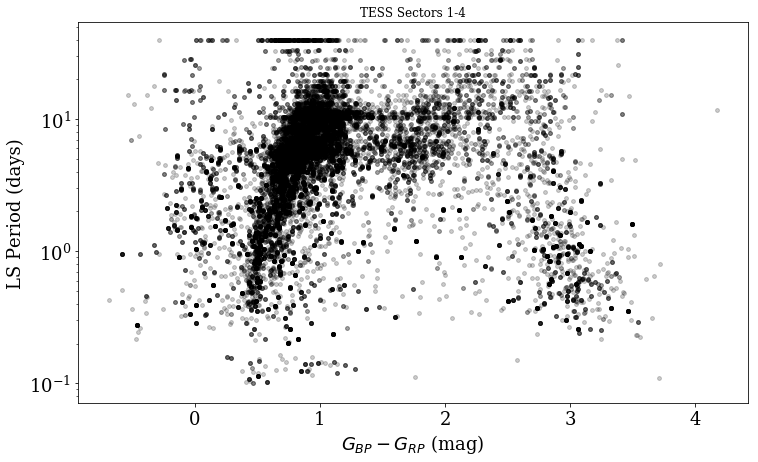

In [48]:
plt.figure(figsize=(12,7))
plt.scatter(gdata['bp_rp'].values[ok], gdata['per'].values[ok], s=15, alpha=0.2, c='k')
plt.yscale('log')
plt.ylabel('LS Period (days)')
plt.xlabel('$G_{BP} - G_{RP}$ (mag)')
plt.title('TESS Sectors 1-4', fontsize=12)
plt.savefig('color_per1_4.jpeg', dpi=150, bbox_inches='tight', pad_inches=0.25)

Text(0.5, 1.0, 'TESS Sectors 1-4')

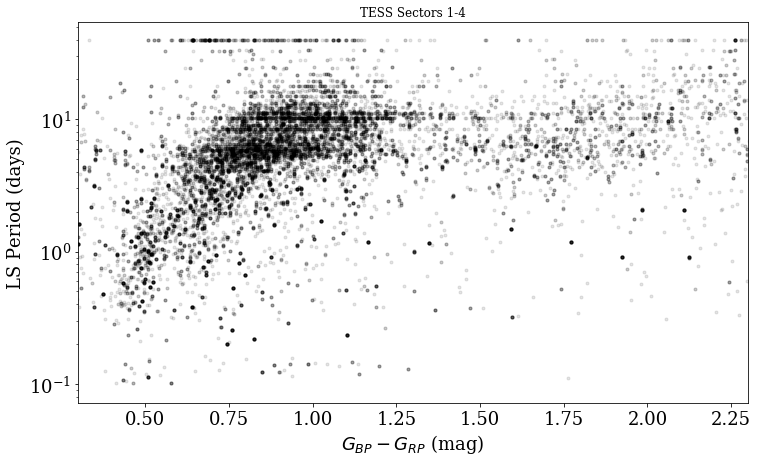

In [49]:
plt.figure(figsize=(12,7))
plt.scatter(gdata['bp_rp'].values[ok], gdata['per'].values[ok], s=9, alpha=0.1, c='k')
plt.yscale('log')
plt.xlim(0.3,2.3)
plt.ylabel('LS Period (days)')
plt.xlabel('$G_{BP} - G_{RP}$ (mag)')
plt.title('TESS Sectors 1-4', fontsize=12)
# plt.savefig('color_per1.jpeg', dpi=150, bbox_inches='tight', pad_inches=0.25)

Text(0.5, 1.0, 'TESS Sectors 1-4')

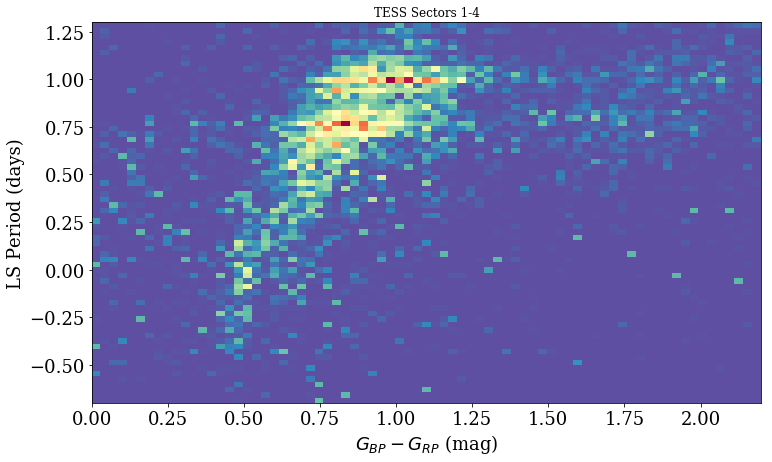

In [50]:
plt.figure(figsize=(12,7))


# plt.scatter(gdata['bp_rp'].values[ok], gdata['per'].values[ok], s=4, alpha=0.1, c='k')
cb,xeb,yeb,ib = plt.hist2d(gdata['bp_rp'].values[ok], np.log10(gdata['per'].values[ok]),
                           range=[[0,2.2],[-.7,1.3]], bins=(75,70), cmap=plt.cm.Spectral_r)
# plt.yscale('log')
# plt.xlim(0.3,2.3)
plt.ylabel('LS Period (days)')
plt.xlabel('$G_{BP} - G_{RP}$ (mag)')
plt.title('TESS Sectors 1-4', fontsize=12)
# plt.savefig('color_per1.jpeg', dpi=150, bbox_inches='tight', pad_inches=0.25)

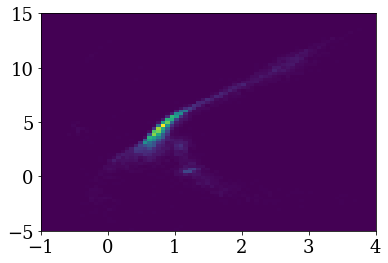

In [51]:
xcb,xeb,yeb,ib = plt.hist2d(gdata['bp_rp'], 
                           gdata['phot_g_mean_mag'] - 5. * np.log10(gdata[u'r_est'].values) + 5, 
                           range=[[-1,4],[-5,15]], bins=(75,75))

(15, -5)

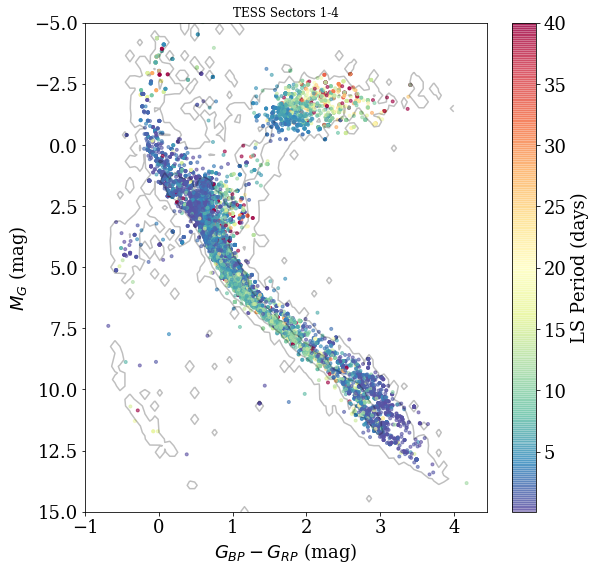

In [53]:

plt.figure(figsize=(9,9))


plt.contour(xcb.T, extent=[xeb.min(),xeb.max(),yeb.min(),yeb.max()], levels=[2,100], colors='k', alpha=0.25)

plt.scatter(gdata['bp_rp'][ok], gdata['phot_g_mean_mag'][ok] - 5. * np.log10(gdata[u'r_est'].values[ok]) + 5, 
            alpha=0.6, s=9, c=(gdata['per'].values[ok]), cmap=plt.cm.Spectral_r)

cbar = plt.colorbar()
cbar.set_label('LS Period (days)')

plt.xlabel('$G_{BP} - G_{RP}$ (mag)')
plt.ylabel('$M_G$ (mag)')
plt.title('TESS Sectors 1-4', fontsize=12)
plt.ylim(15,-5)

# plt.savefig('cmd_per1.jpeg', dpi=150, bbox_inches='tight', pad_inches=0.25)

In [54]:
msbad = np.where((gdata['phot_g_mean_mag'][ok] - 5. * np.log10(gdata[u'r_est'].values[ok]) + 5 > 5) & 
                 (gdata['phot_g_mean_mag'][ok] - 5. * np.log10(gdata[u'r_est'].values[ok]) + 5 < 13) & 
                 (gdata['bp_rp'][ok] > 0.5))[0]
print(np.shape(msbad))

(8325,)


(10.2, 4)

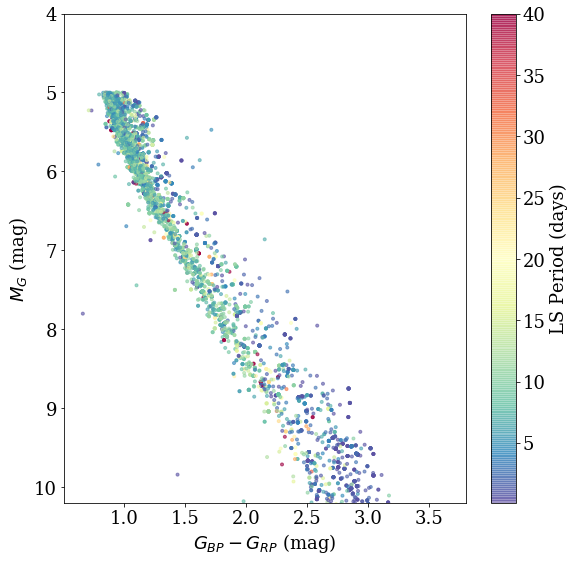

In [55]:

plt.figure(figsize=(9,9))

plt.scatter(gdata['bp_rp'][ok[msbad]], gdata['phot_g_mean_mag'][ok[msbad]] - 5. * np.log10(gdata[u'r_est'].values[ok[msbad]]) + 5, 
            alpha=0.6, s=9, c=(gdata['per'].values[ok[msbad]]), cmap=plt.cm.Spectral_r)

cb = plt.colorbar()
cb.set_label('LS Period (days)')
plt.xlabel('$G_{BP} - G_{RP}$ (mag)')
plt.ylabel('$M_G$ (mag)')
# plt.title('TESS Sectors 1,2', fontsize=12)
plt.ylim(10.2,4)
# plt.xlim(1,2)

# plt.savefig('cmd_per2.jpeg', dpi=150, bbox_inches='tight', pad_inches=0.25)

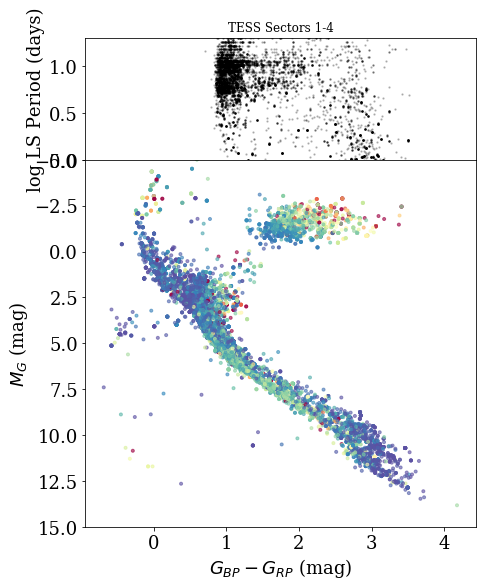

In [57]:


fig, (a0, a1) = plt.subplots(ncols=1, nrows=2, sharex=True, 
                             gridspec_kw = {'height_ratios':[1,3]},
                             figsize=(7,9))

a0.scatter(gdata['bp_rp'].values[ok[msbad]], np.log10(gdata['per'].values[ok[msbad]]), s=2, alpha=0.2, c='k')
# a0.set_yscale('log')
a0.set_ylabel('log LS Period (days)')
# plt.xlabel('$G_{BP} - G_{RP}$ (mag)')
# plt.xlim(0.67,1.7)
a0.set_ylim(0, 1.3)
a0.set_title('TESS Sectors 1-4', fontsize=12)


a1.scatter(gdata['bp_rp'][ok], gdata['phot_g_mean_mag'][ok] - 5. * np.log10(gdata[u'r_est'].values[ok]) + 5, 
            alpha=0.6, s=9, c=(gdata['per'].values[ok]), cmap=plt.cm.Spectral_r)

# cbar = plt.colorbar()
# cbar.set_label('LS Period (days)')

a1.set_xlabel('$G_{BP} - G_{RP}$ (mag)')
a1.set_ylabel('$M_G$ (mag)')
a1.set_ylim(15,-5)

fig.subplots_adjust(hspace=0)

# plt.savefig('cmd_per1.jpeg', dpi=150, bbox_inches='tight', pad_inches=0.25)

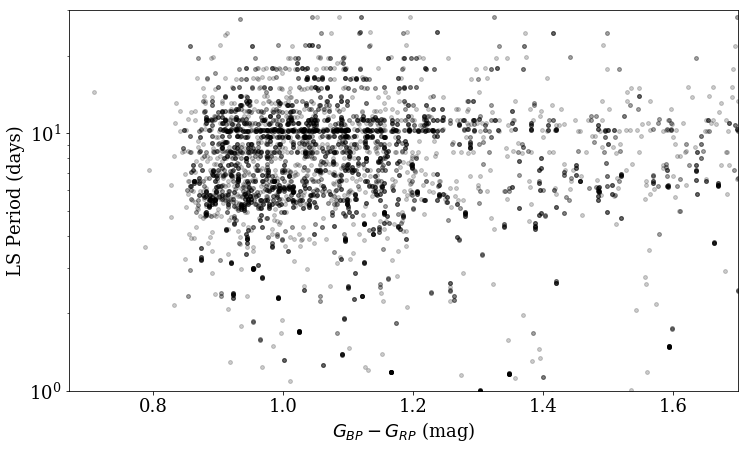

In [58]:
plt.figure(figsize=(12,7))
plt.scatter(gdata['bp_rp'].values[ok[msbad]], gdata['per'].values[ok[msbad]], s=15, alpha=0.2, c='k')
plt.yscale('log')
plt.ylabel('LS Period (days)')
plt.xlabel('$G_{BP} - G_{RP}$ (mag)')
plt.xlim(0.67,1.7)
plt.ylim(1,30)
# plt.title('TESS Sectors 1,2', fontsize=12)
plt.savefig('color_per2_4.jpeg', dpi=150, bbox_inches='tight', pad_inches=0.25)

In [59]:
bc1 = np.where((gdata['ra'][ok] > 0) & 
               (gdata['ra'][ok] < 2.2) & 
               (gdata['dec'][ok] > -31) & 
               (gdata['dec'][ok] < 29))[0]
print(np.shape(bc1))

(94,)


Text(0.5, 1.0, 'Blanco 1')

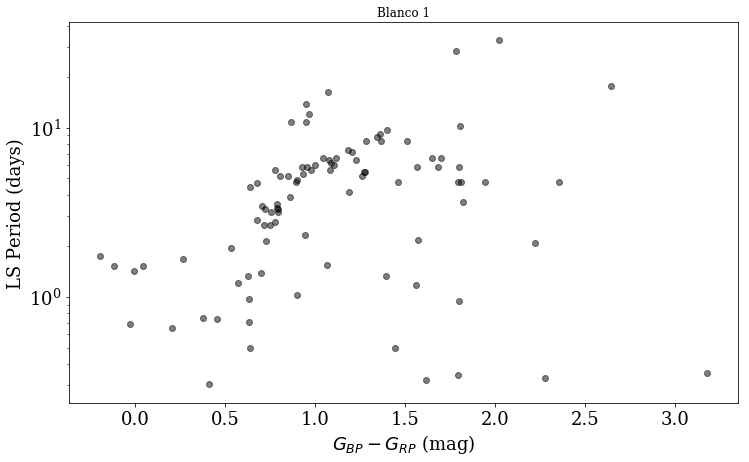

In [60]:

plt.figure(figsize=(12,7))
plt.scatter(gdata['bp_rp'].values[ok[bc1]], gdata['per'].values[ok[bc1]], alpha=0.5, c='k')
plt.yscale('log')
plt.ylabel('LS Period (days)')
plt.xlabel('$G_{BP} - G_{RP}$ (mag)')
plt.title('Blanco 1', fontsize=12)
# plt.savefig('color_per3.jpeg', dpi=150, bbox_inches='tight', pad_inches=0.25)

In [62]:
# s4

array([10601, 10602, 10603, ..., 14894, 14895, 14896])

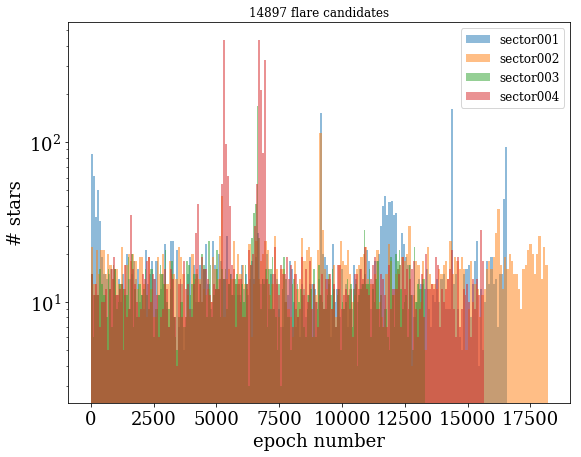

In [63]:
NBINS=200


plt.figure(figsize=(9,7))
# s1 = np.where((FL_id < len(sect1)))[0]
# s2 = np.where((FL_id > len(sect1)) & 
#               (FL_id < len(sect1) + len(sect2)))[0]
# s3 = np.where((FL_id > len(sect1) + len(sect2)))[0]


n1,be1,_ = plt.hist((FL_t0[s1]+FL_t1[s1])/2.,bins=NBINS, alpha=0.5, label='sector001')
n2,be2,_ = plt.hist((FL_t0[s2]+FL_t1[s2])/2.,bins=NBINS, alpha=0.5, label='sector002')
n3,be3,_ = plt.hist((FL_t0[s3]+FL_t1[s3])/2.,bins=NBINS, alpha=0.5, label='sector003')
n4,be4,_ = plt.hist((FL_t0[s4]+FL_t1[s4])/2.,bins=NBINS, alpha=0.5, label='sector004')



plt.title(str(np.size(FL_t0))+' flare candidates',fontsize=12)
plt.xlabel('epoch number')
plt.ylabel('# stars')
plt.legend(fontsize=12)
plt.yscale('log')


In [64]:
print(10**np.mean(np.log10(n1)) + 2 * 10**np.std(np.log10(n1)))
print(10**np.mean(np.log10(n2)) + 2 * 10**np.std(np.log10(n2)))
print(10**np.mean(np.log10(n3)) + 2 * 10**np.std(np.log10(n3)))
print(10**np.mean(np.log10(n4)) + 2 * 10**np.std(np.log10(n4)))

17.93764603240117
18.1500939904658
14.677713104665159
17.591017370635836


In [68]:
FLCUT = 25

OK = np.empty(len(FL_id), dtype='bool') * False
for k in range(len(n1)):
    tt = np.where(#(FL_id[s1] < 15889) & 
                  ((FL_t0[s1]+FL_t1[s1])/2. >= be1[k]) & 
                  ((FL_t0[s1]+FL_t1[s1])/2. < be1[k+1]))[0]
    if n1[k] < FLCUT:
        OK[s1[tt]] = True


for k in range(len(n2)):
    tt = np.where(#(FL_id[s2] >= 15889) & 
                  ((FL_t0[s2]+FL_t1[s2])/2. >= be2[k]) & 
                  ((FL_t0[s2]+FL_t1[s2])/2. < be2[k+1]))[0]
    if n2[k] < FLCUT:
        OK[s2[tt]] = True

        
for k in range(len(n3)):
    tt = np.where(#(FL_id[s3] >= 15889) & 
                  ((FL_t0[s3]+FL_t1[s3])/2. >= be3[k]) & 
                  ((FL_t0[s3]+FL_t1[s3])/2. < be3[k+1]))[0]
    if n3[k] < FLCUT:
        OK[s3[tt]] = True

        
for k in range(len(n4)):
    tt = np.where(#(FL_id[s3] >= 15889) & 
                  ((FL_t0[s4]+FL_t1[s4])/2. >= be4[k]) & 
                  ((FL_t0[s4]+FL_t1[s4])/2. < be4[k+1]))[0]
    if n4[k] < FLCUT:
        OK[s4[tt]] = True


        
sum(OK)

9968

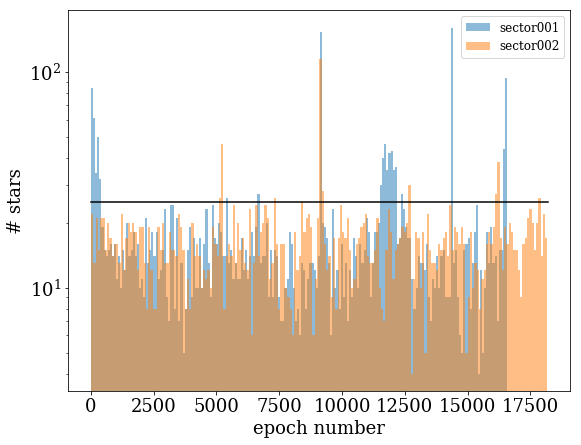

In [69]:
plt.figure(figsize=(9,7))
# s1 = np.where((FL_id < 15889))[0]
# s2 = np.where((FL_id >= 15889))[0]

_ = plt.hist((FL_t0[s1]+FL_t1[s1])/2.,bins=NBINS, alpha=0.5, label='sector001')
_  = plt.hist((FL_t0[s2]+FL_t1[s2])/2.,bins=NBINS, alpha=0.5, label='sector002')
plt.plot([0, max(FL_t1)], [FLCUT, FLCUT], c='k')

# plt.title(str(np.size(FL_t0))+' flare candidates',fontsize=12)
plt.xlabel('epoch number')
plt.ylabel('# stars')
plt.legend(fontsize=12)
plt.yscale('log')


In [70]:
flare_out2 = pd.DataFrame(data={'TIC':ALL_TIC[FL_id], 'i0':FL_t0, 'i1':FL_t1, 
                                'med':FL_f0, 'peak':FL_f1, 'FLOK':OK})
fdata = pd.merge(flare_out2, df, left_on='TIC', right_on='ticid')

(12510,)


(15, -5)

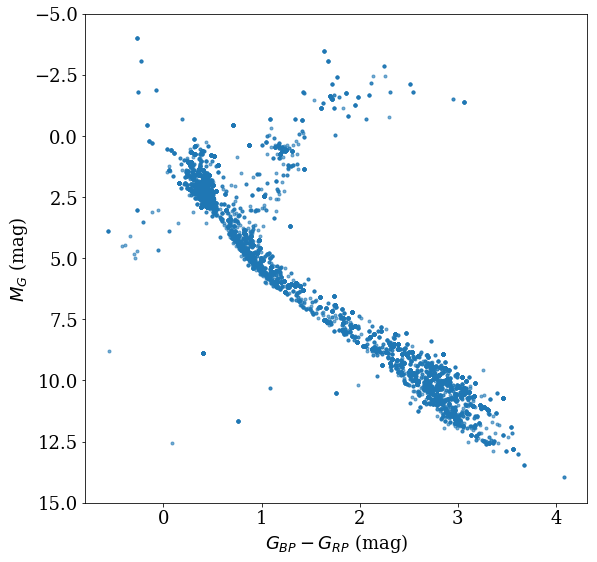

In [71]:
Fok = np.where(np.isfinite(fdata[u'parallax']) & # this is basically the same as the TGAS file...
               (fdata[u'parallax_error'] < 0.1) &
               (fdata[u'modality_flag'] == 1) & 
               (fdata[u'result_flag'] == 1) &
               np.isfinite(fdata[u'bp_rp']) & 
               (fdata[u'phot_bp_mean_flux_error']/fdata[u'phot_bp_mean_flux'] < 0.01) & 
               (fdata[u'phot_rp_mean_flux_error']/fdata[u'phot_rp_mean_flux'] < 0.01) & 
               (fdata[u'phot_g_mean_flux_error']/fdata[u'phot_g_mean_flux'] < 0.01) & 
               (fdata['FLOK'] == True) & 
               (fdata['peak']/fdata['med'] > 0.02))[0]
print(Fok.shape)


plt.figure(figsize=(9,9))

plt.scatter(fdata['bp_rp'][Fok], fdata['phot_g_mean_mag'][Fok] - 5. * np.log10(fdata[u'r_est'].values[Fok]) + 5, 
            alpha=0.6, s=9)

# cb = plt.colorbar()
# cb.set_label('LS Period (days)')
plt.xlabel('$G_{BP} - G_{RP}$ (mag)')
plt.ylabel('$M_G$ (mag)')
# plt.title('TESS Sectors 1,2', fontsize=12)
plt.ylim(15,-5)
# plt.savefig('cmd_per2.jpeg', dpi=150, bbox_inches='tight', pad_inches=0.25)